### Hough transform implementation 

Psuedocode reference: (https://en.wikipedia.org/wiki/Circle_Hough_Transform)

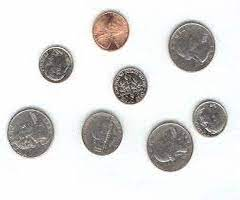

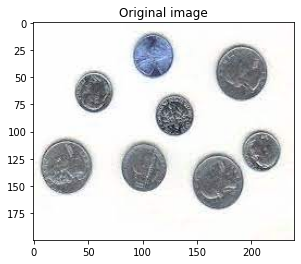

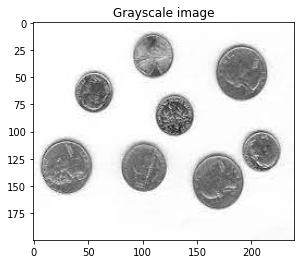

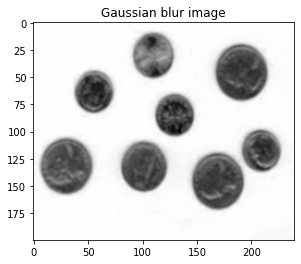

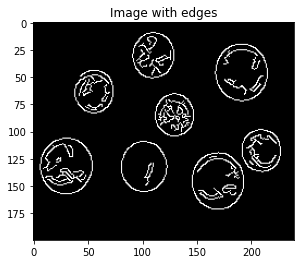

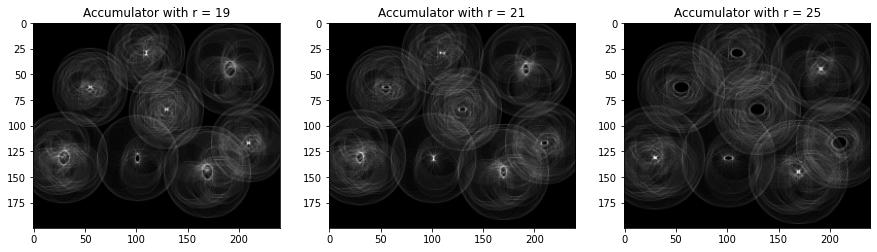

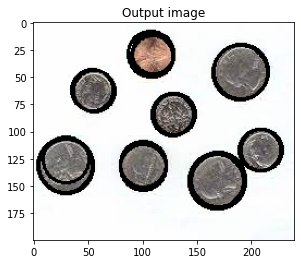

In [7]:
# Import the required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Read the input image given
img = cv2.imread('.\Images\circles.jpeg')
plt.title("Original image")
plt.imshow(img)
plt.show()

# Conver the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.title("Grayscale image")
plt.imshow(gray, cmap='gray')
plt.show()

# apply gaussian blur to the grayscale image
gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)
plt.title("Gaussian blur image")
plt.imshow(gray_blur, cmap='gray')
plt.show()

# find edges using Canny edge detector
edges = cv2.Canny(gray_blur, 50, 150)
plt.title("Image with edges")
plt.imshow(edges, cmap='gray')
plt.show()

# list of radii to be searched in image
# here i have considered 3 different radii
# i.e. 19, 21 and 25
radii = [19, 21, 25]

# create an accumulators array of accummulator
# for storing accummulator of each radii
accumulators = []
pi = 22/7
# for each radius defined above do the following as per wikipedia link given
for r in radii:
    # create an accumulator array of the same size as the image
    accumulator = np.zeros(gray.shape)
    # loop through all the edge pixels
    for x,y in np.argwhere(edges > 0):
      # loop through all possible angles
      for theta in range(0,360):
        # calculate the corresponding center coordinates for this radius and angle
        a = int(x - r * np.cos(theta * pi/180))
        b = int(y - r * np.sin(theta * pi/180))
        # increment the accumulator cell if it is within the image boundary
        if a >= 0 and a < accumulator.shape[0] and b >= 0 and b < accumulator.shape[1]:
          accumulator[a,b] += 1
    accumulators.append(accumulator)

# plot the accumulator spaces for each radii collected above
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Accumulator with r = 19")
plt.imshow(accumulators[0], cmap = 'gray')

plt.subplot(1,3,2)
plt.title("Accumulator with r = 21")
plt.imshow(accumulators[1], cmap = 'gray')

plt.subplot(1,3,3)
plt.title("Accumulator with r = 25")
plt.imshow(accumulators[2], cmap = 'gray')
plt.show()

# define a threshold value for each radii
threshold = [148, 144, 145]

# create a copy of original image to draw circles on
output_img = img.copy()

# loop through each accumulator
for i in range(len(accumulators)):
    # find coordinates of cells that exceed threshold value
    x,y = np.where(accumulators[i] > threshold[i])
    
    # draw circles on output image using these coordinates and corresponding radius value
    for x,y in zip(x,y):
        cv2.circle(output_img,(y,x),radii[i],(0,0,0),2)

# display the output image with circles plotted above
plt.title("Output image")
plt.imshow(output_img[:,:,::-1])
plt.show()

### Harris corner detection implementation

Reference: Lecture notes of Dr. Marnim Galib, University of Texas at Arlington. 

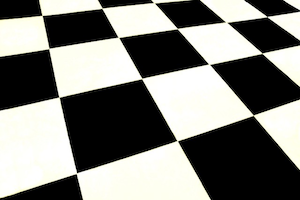

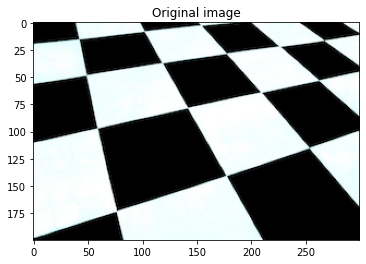

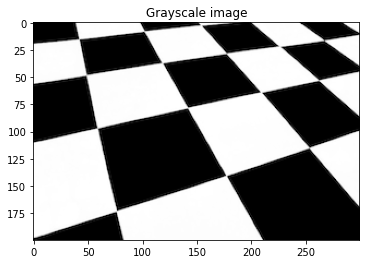

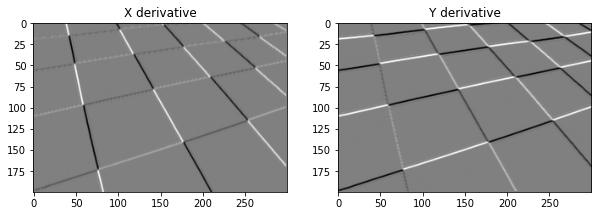

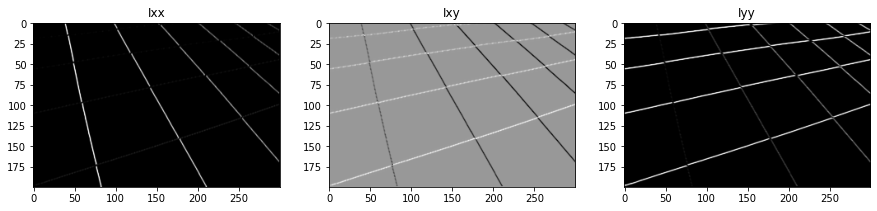

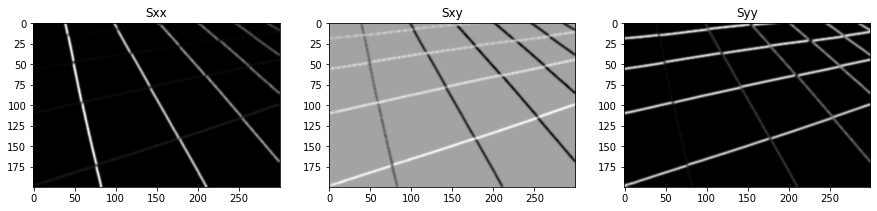

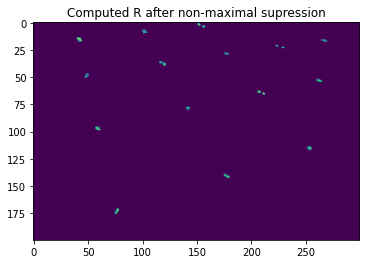

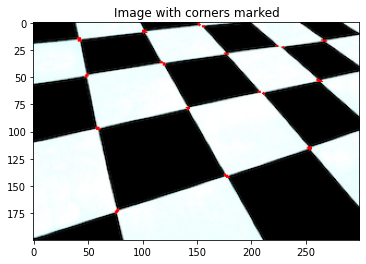

In [8]:
import numpy as np
import cv2
from numpy.linalg import eig
import matplotlib.pyplot as plt

# Read the image
image = cv2.imread(".\Images\checkerboard.png", cv2.COLOR_BGR2GRAY)
plt.title("Original image")
plt.imshow(image)
plt.show()

# convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.title("Grayscale image")
plt.imshow(gray, cmap='gray')
plt.show()

# compute the x and y derivatives i.e. 
# gradients in x and y directions using sobel filter
Ix = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
Iy = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("X derivative")
plt.imshow(Ix, cmap='gray')

plt.subplot(1,2,2)
plt.title("Y derivative")
plt.imshow(Iy, cmap='gray')
plt.show()

# compute the products of derivatives at every pixel
Ixx = Ix * Ix
Ixy = Ix * Iy
Iyy = Iy * Iy

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Ixx")
plt.imshow(Ixx, cmap='gray')

plt.subplot(1,3,2)
plt.title("Ixy")
plt.imshow(Ixy, cmap='gray')

plt.subplot(1,3,3)
plt.title("Iyy")
plt.imshow(Iyy, cmap='gray')
plt.show()

# Compute the sums of the products of derivatives at each pixel
Sxx = cv2.GaussianBlur(Ixx, (5, 5), 0)
Sxy = cv2.GaussianBlur(Ixy, (5, 5), 0)
Syy = cv2.GaussianBlur(Iyy, (5, 5), 0)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Sxx")
plt.imshow(Sxx, cmap='gray')

plt.subplot(1,3,2)
plt.title("Sxy")
plt.imshow(Sxy, cmap='gray')

plt.subplot(1,3,3)
plt.title("Syy")
plt.imshow(Syy, cmap='gray')
plt.show()

# Doing the following for each pixel
R = np.empty(Sxx.shape, dtype='float')
k = 0.06

for i in range(len(Sxx)):
    for j in range(len(Sxx[0])):
        # find the M matrix
        M = [[Sxx[i][j], Sxy[i][j]], [Sxy[i][j], Syy[i][j]]]

        # find eigen values of M matrix
        eval, vector = eig(M)

        # For every pixel find (eval1 * eval2) - (k * (eval1 + eval2)^2) 
        # as per Harris & Stephen formula 
        R[i][j] = (eval[0] * eval[1]) - k*((eval[0] + eval[1])**2)

# Threshold on value of R; compute non-max suppression.
threshold = 0.3 * np.max(R)
R[R < threshold] = 0

# Plotting the R
plt.title("Computed R after non-maximal supression")
plt.imshow(R)
plt.show()

# For the points in R with high values are marked as red on 
# original image 
for i in range(len(R)):
    for j in range(len(R[0])):
        if R[i][j] != 0:
            image[i][j] = (255,0,0)

plt.title("Image with corners marked")
plt.imshow(image)
plt.show()